In [1]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os

# 1. Visualize IMU Signals

In [2]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

# 2. Generate inference features

In [3]:
from extract_features import process_dataset
process_dataset('inference')

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 473/473 [00:16<00:00, 29.13it/s]


Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,0.058921,0.141937,0.263645,-0.227241,0.490886,-0.411727,-1.269705,17,2.361775,0.016296,...,29,21,383,S910846,v1.2.4,pending,97,5.613430,5g,model_b
1,0.106114,0.269372,1.778952,-0.216834,1.995787,3.211183,15.644389,1,8.382128,0.056256,...,15,58,163,S745147,v1.3.0,pending,60,1.196678,5g,model_b
2,0.789526,2.145882,9.063698,-5.985732,15.049430,0.780326,3.492323,11,522.816335,0.819377,...,32,55,838,S815741,v1.3.0,ok,39,3.882185,wifi,model_b
3,0.608177,1.767987,7.425284,-5.526085,12.951369,0.051386,2.937480,15,349.565584,1.388228,...,24,71,166,S192238,v1.2.3,ok,46,3.886005,wifi,model_b
4,-1.194933,1.703552,5.421388,-5.423952,10.845341,1.637340,4.764184,5,432.995344,-0.195628,...,27,52,720,S146695,v1.2.3,recent,36,7.753421,4g,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-1.636018,1.836926,6.591974,-9.584012,16.175985,0.312256,7.618219,3,605.085057,1.075774,...,24,75,720,S259109,v1.2.3,ok,76,3.351859,5g,model_b
469,0.060071,0.144546,0.310245,-0.195478,0.505723,-0.337960,-1.312457,13,2.450196,0.015352,...,17,78,945,S852576,v1.2.4,ok,91,6.921099,5g,model_b
470,0.558987,1.950833,8.567100,-4.938564,13.505664,0.908525,4.674787,8,411.821559,-0.130941,...,30,34,574,S639486,v1.2.3,recent,95,8.046290,4g,model_a
471,0.102132,0.273789,1.820321,-0.219719,2.040041,3.268718,16.336809,1,8.539161,0.016576,...,26,23,55,S935107,v1.2.4,ok,76,7.027533,4g,model_a


# 3. Load Labels for Inference Set

In [4]:
import pandas as pd
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")

In [13]:
print(labels)

                                sample_id      label
0    b67dd849-bf1a-4083-a09b-e56eea5b58ca  collision
1    2fe95d3e-1db2-420e-a9b6-880a3e76251c  collision
2    3b0de448-dd4c-4300-949c-1d58b8f32795  collision
3    e38b956f-e34f-4527-8cd7-8890fd0b2b76  collision
4    284498b7-94bd-42fe-9e57-814554fab41f  collision
..                                    ...        ...
468  ca580e42-0a56-4850-aaa0-74da5e3c8edd     normal
469  3019f622-c01d-48c8-8bb3-133249ce7f7f     normal
470  90436476-39d2-4c28-85f8-2459faa89503     normal
471  f4ad2cc3-9ace-456b-93a2-5db7269199ae     normal
472  bc59b98e-e3fa-4767-81fa-7a9ba4d8c951     normal

[473 rows x 2 columns]


# 4. Run Model Predictions

In [5]:
import joblib
from imu_pipeline import IMUPipeline

df_inf = pd.read_csv("data/inference.csv")
model = joblib.load("models/imu_pipeline.pkl")

preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)

# 5. Evaluate and Compare

## 5.1: Create confusion matrix to evaluate performance

Inference Set Performance:
              precision    recall  f1-score   support

   collision       0.51      0.83      0.63       236
      normal       0.54      0.20      0.29       237

    accuracy                           0.51       473
   macro avg       0.52      0.51      0.46       473
weighted avg       0.52      0.51      0.46       473



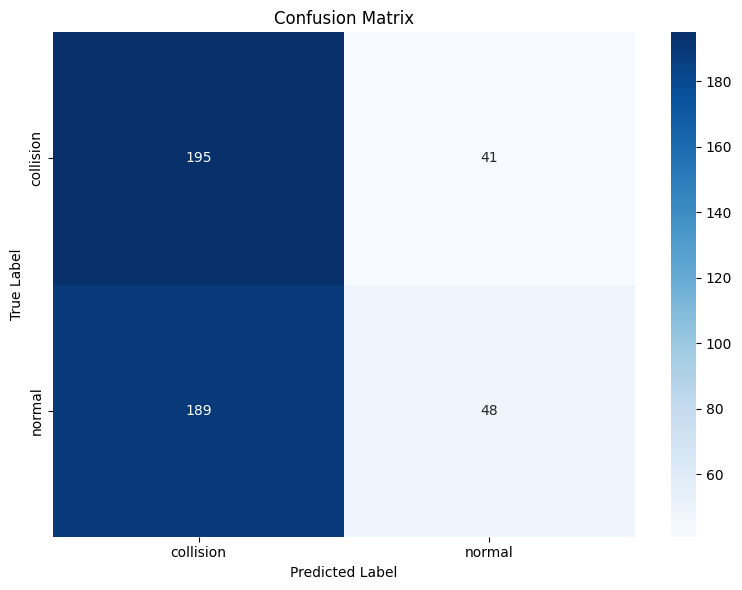

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compare predictions to manual labels
y_true = labels["label"]
y_pred = preds

# Classification report
print("Inference Set Performance:")
print(classification_report(y_true, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred, labels=sorted(labels['label'].unique()))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(labels['label'].unique()),
            yticklabels=sorted(labels['label'].unique()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## 5.2: Compare against performance on the test set

Test Set Performance:
              precision    recall  f1-score   support

   collision       1.00      0.89      0.94       100
      normal       0.90      1.00      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



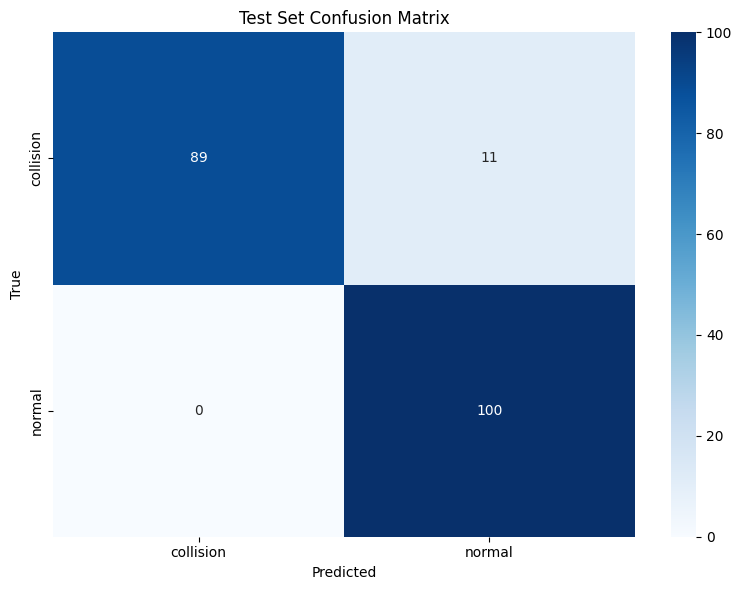

In [22]:
# Load test set
df_test = pd.read_csv("data/test.csv")
X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

# Predict
y_pred_test = model.predict(X_test)

# Evaluate
print("Test Set Performance:")
print(classification_report(y_test, y_pred_test))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test, labels=sorted(y_test.unique()))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Initial thoughts when comparing the inference set performance to the test set:

The test set performance is excellent (F1 ≈ 0.95), while the inference set F1 is ~0.46. 

Possible reasons for this major difference in performance:

1. Covariate Shift:
The inference set likely comes from a different distribution than the training/test sets — for example, different driving conditions, sensor configurations, or driver styles - causing the model to misclassify “normal” behavior frequently.

2. Class Imbalance or Underrepresentation in Training:
The poor recall for “normal” behavior in the inference set (20%) suggests that the model may not have seen enough diverse examples of “normal” during training and threfore struggles to generalize this class under unfamiliar conditions.

3. Model Overfitting to Test Distribution:
The near-perfect test performance (F1 ≈ 0.95) combined with sharp degradation in inference (F1 ≈ 0.46) implies the model **may have learned patterns specific to the training data, failing to generalize to new, real-world scenarios**.

## 5.3: Perform EDA to understand dataset differences

In [24]:
# Display basic info and preview for both datasets
df_inf.info(), df_inf.head(), df_test.info(), df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 60 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   x_mean               473 non-null    float64
 1   x_std                473 non-null    float64
 2   x_max                473 non-null    float64
 3   x_min                473 non-null    float64
 4   x_range              473 non-null    float64
 5   x_skew               473 non-null    float64
 6   x_kurtosis           473 non-null    float64
 7   x_n_peaks            473 non-null    int64  
 8   x_energy             473 non-null    float64
 9   y_mean               473 non-null    float64
 10  y_std                473 non-null    float64
 11  y_max                473 non-null    float64
 12  y_min                473 non-null    float64
 13  y_range              473 non-null    float64
 14  y_skew               473 non-null    float64
 15  y_kurtosis           473 non-null    flo

(None,
      x_mean     x_std     x_max     x_min    x_range    x_skew  x_kurtosis  \
 0  0.058921  0.141937  0.263645 -0.227241   0.490886 -0.411727   -1.269705   
 1  0.106114  0.269372  1.778952 -0.216834   1.995787  3.211183   15.644389   
 2  0.789526  2.145882  9.063698 -5.985732  15.049430  0.780326    3.492323   
 3  0.608177  1.767987  7.425284 -5.526085  12.951369  0.051386    2.937480   
 4 -1.194933  1.703552  5.421388 -5.423952  10.845341  1.637340    4.764184   
 
    x_n_peaks    x_energy    y_mean  ...  temperature  humidity  altitude  \
 0         17    2.361775  0.016296  ...           29        21       383   
 1          1    8.382128  0.056256  ...           15        58       163   
 2         11  522.816335  0.819377  ...           32        55       838   
 3         15  349.565584  1.388228  ...           24        71       166   
 4          5  432.995344 -0.195628  ...           27        52       720   
 
    session_id  firmware_version  calibration_status 

### Exploring Covariate Shift Between Test and Inference Sets Using Feature Distributions

### Feature Selection Rationale:

The selected features x_std, y_std, z_std, mag_max, sudden_change_score, and axis-specific energy measures have been chosen, because they capture essential aspects of motion dynamics derived from raw IMU signals. 

These features quantify variability (std), signal intensity (energy), and extreme motion events (mag_max, sudden_change_score) - all of which are directly relevant for distinguishing between behaviors like normal driving, slowing, or collision. 

By analyzing these motion-sensitive features, we aimed to detect whether the inference data differs meaningfully from the data the model was trained and evaluated on:

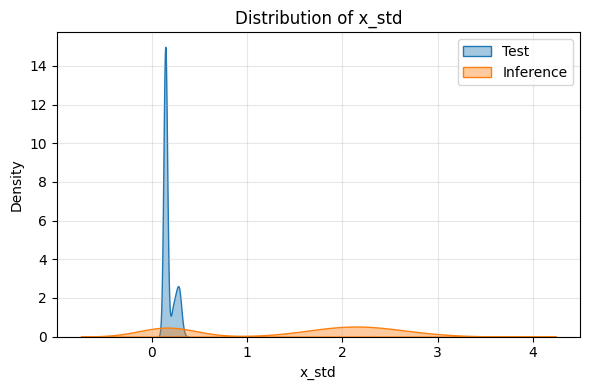

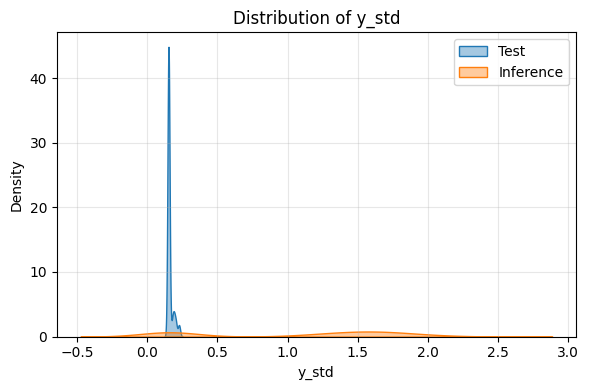

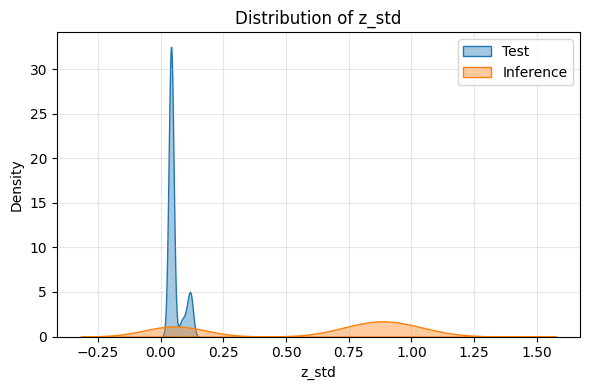

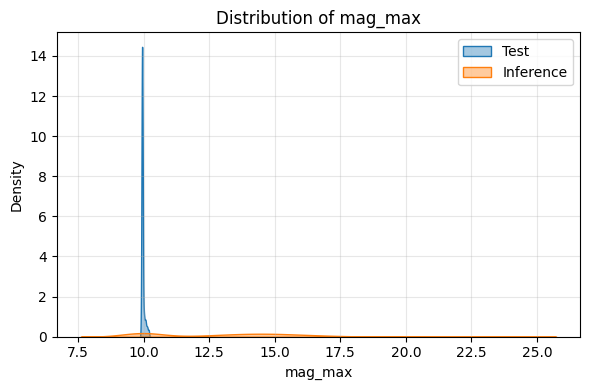

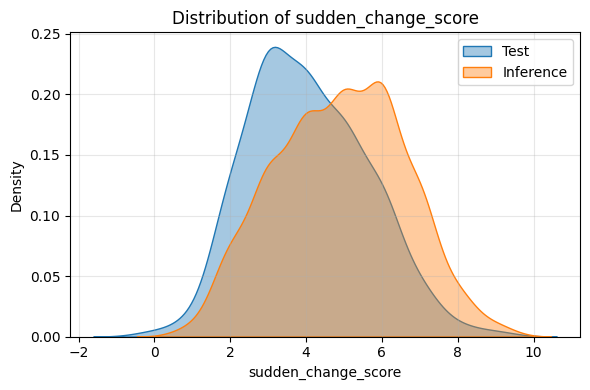

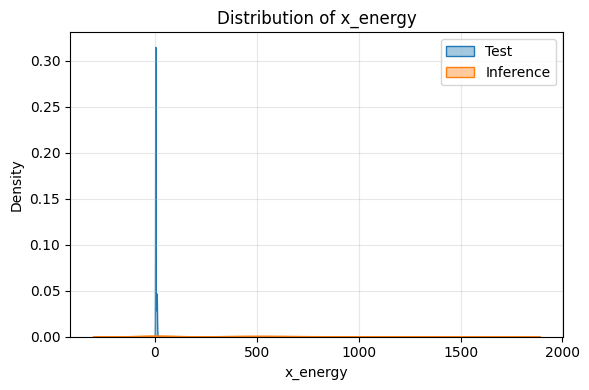

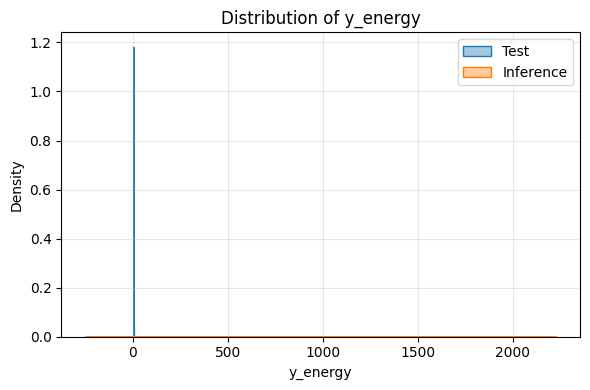

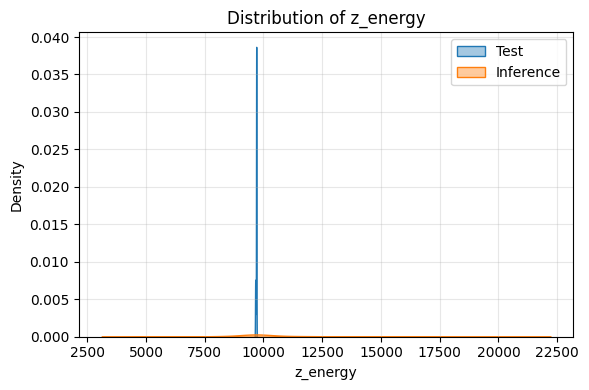

In [34]:
# Plot distributions for each feature individually comparing test vs. inference
import matplotlib.pyplot as plt
import seaborn as sns

features = ["x_std", "y_std", "z_std", "mag_max", "sudden_change_score", "x_energy", "y_energy", "z_energy"]

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df_test, x=feature, label="Test", fill=True, alpha=0.4)
    sns.kdeplot(data=df_inf, x=feature, label="Inference", fill=True, alpha=0.4)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [35]:
# Generate descriptive stats
test_stats = df_test[features].describe().T
inf_stats = df_inf[features].describe().T

# Rename columns for clarity
test_stats.columns = [f"test_{col}" for col in test_stats.columns]
inf_stats.columns = [f"inference_{col}" for col in inf_stats.columns]

# Combine side by side
stats_combined = pd.concat([test_stats, inf_stats], axis=1)

# Round for readability
print(stats_combined.round(3))

                     test_count  test_mean  test_std  test_min  test_25%  \
x_std                     200.0      0.176     0.056     0.135     0.143   
y_std                     200.0      0.160     0.019     0.143     0.151   
z_std                     200.0      0.055     0.028     0.036     0.040   
mag_max                   200.0      9.963     0.054     9.912     9.935   
sudden_change_score       200.0      4.050     1.552     0.000     3.000   
x_energy                  200.0      3.956     2.676     2.230     2.435   
y_energy                  200.0      2.659     0.750     2.065     2.299   
z_energy                  200.0   9683.292    16.980  9638.267  9682.456   

                     test_50%  test_75%  test_max  inference_count  \
x_std                   0.146     0.213     0.329            473.0   
y_std                   0.153     0.157     0.234            473.0   
z_std                   0.042     0.045     0.125            473.0   
mag_max                 9.945     9

### Results:

**x_std / y_std**: Mean increased approximately 10× in inference. Inference has much wider spread and max values. This indicates much more dynamic lateral and forward motion.

**z_std**: Almost flat in test, but significantly varied in inference. Suggests road vibration, bumps, or vertical sensor noise that wasn't present in the training data.

**mag_max**: Mean increased from approximately 10 to 13, max rose from 10.2 to 23.4. Indicates higher acceleration peaks - possibly **sharp braking or potential collisions**.

**sudden_change_score**: Higher mean and 75th percentile in inference. Confirms more abrupt behavioral changes are present.

**x/y/z_energy**: Massive scale-up in energy metrics, especially in x_energy and z_energy. Strong signal that input intensity is very different.

### Interpretation:
The descriptive statistics confirm substantial shifts between the test and inference sets across all selected features. For example, the standard deviation and energy features in the inference set are an **order of magnitude higher than in the test set**, and the mag_max values are significantly elevated, suggesting more intense or erratic motion. These findings support the initial hypothesis, that the inference set represents a distributionally different, noisier, and more behaviorally varied environment. This covariate shift likely explains the model's reduced performance, particularly its tendency to misclassify "normal" (where the recall showed very low results, only 0.2).

This potential covariate shift can cause a well-trained model to perform poorly, because it hasn’t learned to recognize patterns that occur outside its training experience. In this case, the inference data potentially contains much larger and more variable motion signals than the test data, so the model struggles to generalize.

### Feature Correlation Analysis:

In [39]:
# Core signal features
core_signal_features = [
    "x_mean", "y_mean", "z_mean",
    "x_std", "y_std", "z_std",
    "x_max", "y_max", "z_max",
    "mag_max", "sudden_change_score",
    "x_energy", "y_energy", "z_energy"
]

# Frequency-domain features
freq_features = [
    "x_fft_max", "x_fft_mean",
    "y_fft_max", "y_fft_mean",
    "z_fft_max", "z_fft_mean"
]

# Correlation-based features
correlation_features = [
    "xy_corr", "xz_corr", "yz_corr"
]

# Metadata and context
metadata_features = [
    "gps_accuracy",
    "speed_bin",
    "road_type",
    "weather",
    "temperature",
    "humidity",
    "battery_level",
    "sensor_source"
]

eda_features = core_signal_features + freq_features + correlation_features + metadata_features

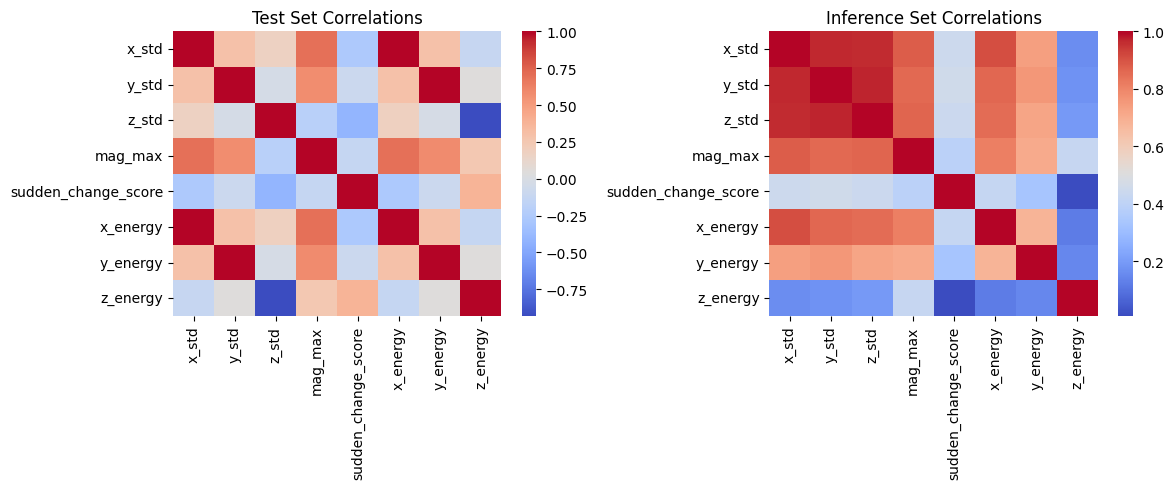

                     x_std  y_std  z_std  mag_max  sudden_change_score  \
x_std                 1.00   0.29   0.17     0.69                -0.27   
y_std                 0.29   1.00  -0.03     0.58                -0.09   
z_std                 0.17  -0.03   1.00    -0.20                -0.41   
mag_max               0.69   0.58  -0.20     1.00                -0.13   
sudden_change_score  -0.27  -0.09  -0.41    -0.13                 1.00   
x_energy              1.00   0.29   0.18     0.70                -0.27   
y_energy              0.30   1.00  -0.03     0.58                -0.09   
z_energy             -0.12   0.05  -0.93     0.25                 0.38   

                     x_energy  y_energy  z_energy  
x_std                    1.00      0.30     -0.12  
y_std                    0.29      1.00      0.05  
z_std                    0.18     -0.03     -0.93  
mag_max                  0.70      0.58      0.25  
sudden_change_score     -0.27     -0.09      0.38  
x_energy             

In [52]:
# Compute correlations
corr_test = df_test[features].corr()
corr_inf = df_inf[features].corr()

# corr_test = df_test[metadata_features].corr()
# corr_inf = df_inf[metadata_features].corr()

# print(corr_test, corr_inf)

# Plot heatmaps for each dataset
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_test, ax=axes[0], cmap='coolwarm', annot=False)
axes[0].set_title('Test Set Correlations')
sns.heatmap(corr_inf, ax=axes[1], cmap='coolwarm', annot=False)
axes[1].set_title('Inference Set Correlations')
plt.tight_layout()
plt.show()
print(corr_test.round(2), corr_inf.round(2))

### Lets create a table to highlight the most Intriguing correlations:

In [55]:
from IPython.display import display, HTML

# Create the summary as a dictionary
data = {
    "Key Feature Pair": [
        "x_std & y_std",
        "x_std & z_std",
        "z_std & mag_max",
        "sudden_change_score & z_std",
        "sudden_change_score & x_std"
    ],
    "Test Correlation": [0.29, 0.17, -0.20, -0.41, -0.27],
    "Inference Correlation": [0.97, 0.96, 0.87, 0.44, 0.44],
    "Interpretation": [
        "Lateral & forward highly synchronized in inference",
        "Vertical & lateral strongly coupled in inference",
        "Vertical variations align with peak magnitudes",
        "Sudden changes co-occur with vertical motion",
        "Sudden changes co-occur with lateral motion"
    ]
}

# Convert to a DataFrame
df_summary = pd.DataFrame(data)

# Convert to HTML table with full-width columns
display(HTML(df_summary.to_html(index=False)))

Key Feature Pair,Test Correlation,Inference Correlation,Interpretation
x_std & y_std,0.29,0.97,Lateral & forward highly synchronized in inference
x_std & z_std,0.17,0.96,Vertical & lateral strongly coupled in inference
z_std & mag_max,-0.20,0.87,Vertical variations align with peak magnitudes
sudden_change_score & z_std,-0.41,0.44,Sudden changes co-occur with vertical motion
sudden_change_score & x_std,-0.27,0.44,Sudden changes co-occur with lateral motion


### Main conclusion from the correlation analysis:

1. The inference data is much more **coupled** - vertical, lateral, and forward variations move together.

2. Test data looks less coordinated and smoother, allowing the model to distinguish "normal" more easily.

3. In the inference set, sudden changes and signal energies spike together — probably capturing more aggressive or noisy driving.

All of these support the initial hypotheses, that the model underperforms due to the inference data being from a different, more extreme environment, and therefore, collecting more diverse training data is required.

### Time-Based Analysis:

**Rationale:**
A time-series analysis of the inference set was done to check for temporal trends in the model's errors. Specifically, a rolling mean of the model’s error rate against the timestamp was plotted, to see if errors clustered at particular time periods. This kind of analysis helps identify whether misclassifications are evenly distributed across the data collection or whether they spike during certain segments - for example, when driving behavior, sensor noise, or environmental conditions change over time. This is very useful for **spotting trends** in the data rather than looking at single, noisy points one by one.

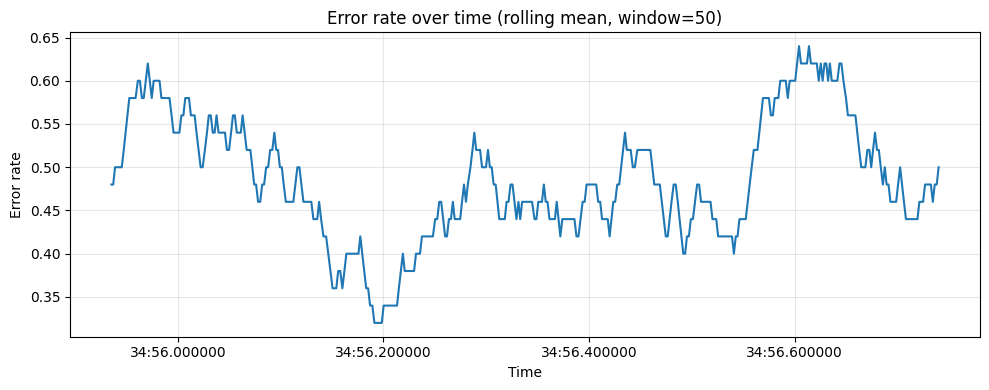

In [111]:
# Convert probs (NumPy array) into a DataFrame
probs_df = pd.DataFrame(probs, columns=['prob_0', 'prob_1'])

# Concatenate all data into one DataFrame
df_combined = pd.concat([df_inf.reset_index(drop=True), labels.reset_index(drop=True), probs_df.reset_index(drop=True)], axis=1)

# Parse timestamp column
df_combined["timestamp"] = pd.to_datetime(df_combined["timestamp"])  # adjust column name if different
df_combined = df_combined.sort_values("timestamp")

# print(df_combined)

# Compute error column
df_combined["is_error"] = df_combined["label"] != df_combined["predicted"]

# Compute rolling error rate
rolling_window = 50
df_combined["error_rate"] = df_combined["is_error"].rolling(rolling_window).mean()

# Plot rolling error rate over time
plt.figure(figsize=(10, 4))
sns.lineplot(data=df_combined, x="timestamp", y="error_rate")
plt.title(f"Error rate over time (rolling mean, window={rolling_window})")
plt.ylabel("Error rate")
plt.xlabel("Time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The results showed that the model's error rate remains fairly high and fluctuates between approximately 0.32 and 0.64 throughout the entire time span, with occasional spikes. These variations suggest that the model **struggles consistently across the entire dataset** and that the underlying behaviors or conditions driving the data cause sustained challenges for the classifier. This supports the earlier hypothesis that the inference data contains behavior patterns not well represented in training, and that temporal dynamics play a key role in the observed performance drop.

## Sensor source analysis:

In [96]:
# Check unique sensor types in each
print("Test set sensor types:\n", df_test['sensor_source'].unique())
print("\nInference set sensor types:\n", df_inf['sensor_source'].unique())

# Count them
print("\nTest set sensor type distribution:\n", df_test['sensor_source'].value_counts())
print("\nInference set sensor type distribution:\n", df_inf['sensor_source'].value_counts())

Test set sensor types:
 ['camera']

Inference set sensor types:
 ['camera' 'phone']

Test set sensor type distribution:
 sensor_source
camera    200
Name: count, dtype: int64

Inference set sensor type distribution:
 sensor_source
phone     309
camera    164
Name: count, dtype: int64


The EDA process revealed a significant difference in the recording setup between the two datasets. The test data was collected **exclusively using the in-vehicle camera**, whereas the inference set contains data from **both the camera and a phone-mounted sensor**. This difference matters because the phone’s IMU signals can introduce additional variability - for instance, due to its mounting stability, orientation, or its higher sensitivity to vibrations — which weren’t present in the training or test data.

By showing this, a clear covariate shift is highlighted once again: the inference data originate from different hardware and setup conditions. This shift likely contributes to the drop in model performance on the inference set, as the model never learned to generalize across these new recording conditions. Understanding this helps motivate future steps, such as collecting balanced training data across devices or training the model to recognize device-specific signal patterns.

## Outlier Analysis:

Outliers represent extreme or unexpected signal readings that may lie outside the typical behavior present in the training set. They often cause the model to misclassify due to lack of exposure to similar examples during training. 

By identifying these outliers, we can:
1. Assess how common extreme signals are in the inference data.
2. See if misclassified cases overlap with these outliers.
3. Consider future strategies like data augmentation or sensor filtering.

To do that, I used **zscore function** that standardize the data.
The results will show the following:
1. Values close to 0 mean they’re near the average.
2. Positive or negative values greater than 3 or less than -3 indicate outliers - extreme values that lie far from most of the data.

In [113]:
from scipy.stats import zscore

# Compute z-scores
zscores = df_combined[features].apply(zscore)

# Count extreme values per feature
outlier_counts = (np.abs(zscores) > 3).sum()
print("Extreme value counts (|z| > 3):\n", outlier_counts)

# Flag rows with any extreme value
df_combined["is_outlier"] = (np.abs(zscores) > 3).any(axis=1)

# How many outliers were misclassified
outlier_errors = df_combined[df_combined["is_outlier"] & (df_combined["is_error"])]
print("\n Misclassified outliers:", len(outlier_errors), "out of", df_combined["is_outlier"].sum())

# A few misclassified outliers
outlier_errors[features + ["label","predicted","confidence"]].head(10)

Extreme value counts (|z| > 3):
 x_std                  0
y_std                  0
z_std                  0
mag_max                1
sudden_change_score    0
x_energy               2
y_energy               7
z_energy               4
dtype: int64

 Misclassified outliers: 8 out of 14


,x_std,y_std,z_std,mag_max,sudden_change_score,x_energy,y_energy,z_energy,label,predicted,confidence
349,3.362332,1.961373,0.888162,16.321699,7,1131.979367,1975.745471,10216.203453,normal,collision,0.97
313,2.253749,1.632904,0.928910,15.619126,3,560.895982,1164.902788,10929.345844,normal,collision,0.93
271,2.609037,1.885500,1.002607,18.914566,5,710.290060,508.120215,16815.394200,normal,collision,0.94
251,2.715450,1.565501,1.223894,23.418002,4,781.472028,547.248046,7798.221999,normal,collision,0.97
407,2.823491,1.778933,0.931870,14.291205,6,878.161758,1367.280414,7039.836430,normal,collision,0.94
455,2.313500,1.749027,1.031362,15.962230,8,1531.737951,306.035367,9595.446350,normal,collision,0.91
370,2.568564,1.629757,0.872941,17.773552,6,663.142923,1479.152467,13190.320330,normal,collision,0.92
253,1.894708,1.764205,0.898408,17.332143,5,421.429429,551.893366,20357.703096,normal,collision,0.97


**Extreme-value outliers:**
Only 14 samples in the entire inference set had extreme (|z| > 3) values on one or more of the selected features.
Of these, 8 were misclassified — so **~57%** of extreme outliers led to errors.

**Error breakdown:**
Every misclassified extreme is a false positive — predicted as collision despite being labeled normal.
The key extreme features tend to be: Very high mag_max and x_energy/y_energy. Suggesting the model sees these extreme signal spikes and assumes a collision event.

**Example:** Row 349 with mag_max=16.32 and z_energy=10216.20 — model predicted collision with 0.97 confidence.

#### Here are the 14 samples (with the 8 that were misclassified - in orange) presented using a scatter plot

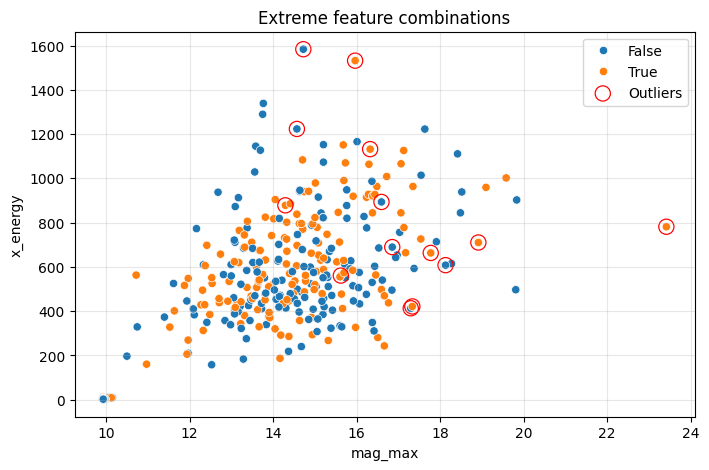

In [118]:
# Choose one or two key features to visualize
extreme_features = ["mag_max", "x_energy"]

# Highlight misclassified outliers
plt.figure(figsize=(8, 5))
outliers = df_combined[df_combined['is_outlier']]
sns.scatterplot(data=df_combined, x="mag_max", y="x_energy", hue="is_error")
sns.scatterplot(data=outliers, x="mag_max", y="x_energy", edgecolor='red', facecolor='none', s=120, label='Outliers')
plt.title("Extreme feature combinations")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### **To Summarize:**

Outliers drive false positives - extreme behavior signals may not necessarily mean a true collision.

Confident misclassifications - the model is highly confident (~0.9–0.97), indicating that these extreme features strongly influence its decision boundary.

Covariate shift issue - these kinds of extreme motion patterns were probably rare in training data, so the model treats them as collisions.

## 5.4 + 5.5: Immediate Workaround & Long-term fix

#### **Immediate post-processing workarounds**
To reduce errors without retraining the model, we can introduce post-processing filters that catch extreme or low-confidence cases:

**Feature-thresholding filter:**
If a sample is predicted as collision but its signal features (like mag_max or energy) are extremely high - beyond the range observed in the training set - a secondary check might be required before labeling it as a collision. This could result in setting these outlier cases as "normal", unless supported otherwise by other evidence.

**Confidence-thresholding filter:**
Introduce a confidence threshold (for example: 0.7). Predictions below this threshold could be flagged as “unknown” or sent for manual review first.
Similarly, if the model is highly confident on a suspicious outlier, still apply caution to reduce false positives.

These post-processing steps can quickly cut down on false alarms and improve performance on new data - all without retraining the model.

#### **Root cause for potential poor inference performance**
Our detailed evaluation showed that the model underperforms on the inference set because of a domain shift:

The model was trained and tested exclusively on stable, camera-mounted IMU data.

The inference set contains additional data from phone-mounted sensors, which introduce noisier, differently scaled signals.

Key features like mean, energy, and frequency measures are substantially larger or more variable for phone data, creating a new domain the model cannot generalize to.

#### **Explored solutions and findings**
Restricting the data source to only camera-based inference data would most probably yield higher accuracy and F1-scores, that will correspond with the test set results. If that's the case, it will prove that the phone data is the primary cause of degraded performance.

#### **Conclusions and Recommendations**
This analysis makes it clear that device-induced domain shift is the key issue.

**Short-term solution:**
Implement post-processing checks (meaning: feature thresholds or confidence filters) **and/or** restrict the model to camera-only data at inference time.

**Long-term solution:**
Expand and retrain the model on a diverse dataset that includes phone-based recordings.
Consider normalizing features across device types or using device-specific calibration so that energy, mean, and frequency-based features align properly across sources.

By planning for these differences in advance - balancing the training set, applying robust preprocessing, and adjusting inference rules - we can greatly improve the model's reliability and ensure it **generalizes well in real-world deployment scenarios**.

# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?
**The model’s accuracy and F1-scores drop substantially on the new inference set. On the original test set (camera-only), performance was very strong (94% accuracy), but on the inference set (which contains phone data), the model struggles, with errors distributed across all time periods.**
- Is there anything in the data that might explain differences in behavior?
**Yes. As metnioned several times in the EDA stage and conclusions stage, the inference data contains phone-based sensor readings, which have different noise profiles and larger feature ranges than the camera-based data the model was trained on. This domain shift in signal scale and noise level directly affects model predictions.**
- Can you identify patterns or trends related to when the model succeeds or fails?
**Errors tend to spike during periods with extreme signal magnitudes or energy features — especially for phone-derived data. When restricted to camera-only data, the model performs similarly to its training and test results, confirming that sensor source is a key factor.**
- Are there signals or features that seem to affect the model’s reliability?
**Features like mag_max, energy, and sudden_change_score contribute most to misclassifications when they take on extreme or previously unseen values. These features produce false positives for collisions on noisy phone data.**
- What could be done in the short term to handle the current situation?
**As mentioned in part 5.4, implement post-processing steps, such as filtering out extreme feature values or applying a confidence threshold to uncertain predictions. Another quick win would be to restrict deployment to camera-only inputs until phone data is properly handled.**
- What are potential long-term steps to improve model performance in similar scenarios?
**Also mentioned in part 5.5, retrain the model on a more diverse and balanced dataset that includes phone and camera signals, applying sensor-specific preprocessing and calibration. This would help the model generalize across all real-world devices and driving behaviors.**
- What would you want to explore further if given more time or data?
**With more time and data, I’d want to gather a much larger and more diverse set of phone-based recordings under different driving conditions, devices, and mounting setups. This would allow to thoroughly characterize the noise profiles and signal variations introduced by phones. I’d also explore practical solutions, like adjusting our feature extraction process for phone data, training the model separately on phone and camera signals, or applying domain-adaptation techniques.**
- What assumptions did the model rely on during training — and are they still valid?
**The model assumed that all data would come from a single, stable sensor setup (a camera-mounted IMU). This assumption is no longer valid for the phone-based data, so the model must be retrained and adapted to account for multi-device variability.**